In [1]:
import numpy as np
import pandas as pd
from dateutil import parser
from datetime import datetime
from statsmodels.tsa.stattools import adfuller

import os
import tensorflow.keras.utils as ku
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Bidirectional, Dropout, LSTM, Dense, Embedding, Flatten, GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable = True)

In [2]:
dataClima = pd.read_csv("./dados_clima.csv", index_col = 'data', parse_dates = True)

In [3]:
dataClima.dropna(inplace=True)
dataClima.drop(columns=["Estacao", "cidade", "estado", "fonte"], inplace=True)
dataClima.reset_index(drop = True, inplace = True)

In [4]:
dataClima.loc[dataClima["precipitacao"] > 0, "chove"] = 1
dataClima.loc[dataClima["precipitacao"] == 0, "chove"] = 0
dataClima

,altitude,insolacao,latitude,longitude,precipitacao,tmax,tmin,ur,chove
0,130.0,12.4,-19.01,-57.65,1.2,33.6,24.4,59.25,1.0
1,130.0,12.3,-19.01,-57.65,0.0,35.6,21.5,60.75,0.0
2,130.0,12.4,-19.01,-57.65,0.0,37.2,23.8,58.75,0.0
3,130.0,12.2,-19.01,-57.65,0.0,37.4,23.7,57.25,0.0
4,130.0,7.0,-19.01,-57.65,0.0,35.0,23.8,67.50,0.0
...,...,...,...,...,...,...,...,...,...
211945,650.0,8.5,-26.05,-53.04,0.0,33.4,19.0,60.90,0.0
211946,650.0,9.0,-26.05,-53.04,0.0,32.8,21.6,59.50,0.0
211947,650.0,10.3,-26.05,-53.04,0.0,35.2,18.6,57.10,0.0
211948,650.0,6.8,-26.05,-53.04,0.0,34.2,21.0,66.40,0.0


In [5]:
# Separando X e y
X = dataClima.drop(columns=["precipitacao", "chove"])
y = dataClima["chove"]

In [6]:
# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Dense

In [7]:
## Definicao do Modelo
modelSimples = Sequential()
modelSimples.add(Dense(32, input_shape = (X_train.shape[1],)))
modelSimples.add(Dense(16, activation="relu"))
modelSimples.add(Dropout(0.2))
modelSimples.add(Dense(1, activation = 'sigmoid'))

optimizer = "RMSprop"
modelSimples.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ["accuracy"])
modelSimples.summary()
## Definicao do Modelo

## Fit
hist = modelSimples.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 64, epochs = 10, verbose = 1)
## Fit

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Train on 169560 samples, validate on 42390 samples
Epoch 1/10
169560/169560 [==============================] - 6s 38us/sample - loss: 0.8583 - accuracy: 0.6550 - val_loss: 0.5720 - val_accuracy: 0.6581
Epoch 2/10
169560/169560 [============================

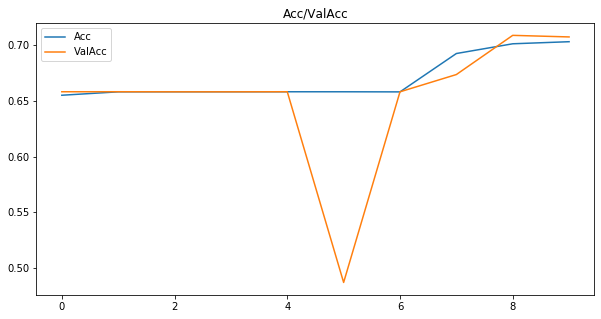

In [8]:
## Plot simples
fig = plt.figure(figsize=(10, 5))
plt.plot(hist.history["accuracy"], label='Acc')
plt.plot(hist.history["val_accuracy"], label='ValAcc')
plt.legend()
plt.title('Acc/ValAcc')
plt.show()
## Plot simples

In [9]:
# RMS
y_predict = modelSimples.predict(X_test)
rms = sqrt(mean_squared_error(y_test, y_predict))
print(rms)

0.44174284908193096


# LSTM

In [10]:
# Ajustes de shape para LSTM
XNew = np.array(dataClima.drop(columns=["precipitacao"]))

timesToDevide = 5
newDataSet = XNew.reshape(((int(XNew.shape[0]/timesToDevide)), timesToDevide, XNew.shape[1]))

X = newDataSet[:,:,0:7]
y = newDataSet[:,:,-1]

In [11]:
# Novamente divisao dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [12]:
## Definicao do Modelo
modelLSTM = Sequential()
modelLSTM.add(LSTM(32, input_shape = (timesToDevide, X_train.shape[2]), return_sequences=True))
modelLSTM.add(LSTM(16, dropout = 0.2, recurrent_dropout = 0.2))
modelLSTM.add(Dense(timesToDevide, activation = 'sigmoid'))

optimizer = "RMSprop"
modelLSTM.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ["accuracy"])
modelLSTM.summary()
## Definicao do Modelo

## Fit
hist = modelLSTM.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 64, epochs = 10, verbose = 1)
## Fit

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             5120      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 85        
Total params: 8,341
Trainable params: 8,341
Non-trainable params: 0
_________________________________________________________________
Train on 33912 samples, validate on 8478 samples
Epoch 1/10
33912/33912 [==============================] - 8s 241us/sample - loss: 0.5988 - accuracy: 0.6720 - val_loss: 0.5401 - val_accuracy: 0.7191
Epoch 2/10
33912/33912 [==============================] - 5s 143us/sample - loss: 0.5439 - accuracy: 0.7169 - val_loss: 0.5112 - val_accuracy: 0.7438
Epoch 3/10
33912/33912 [=========

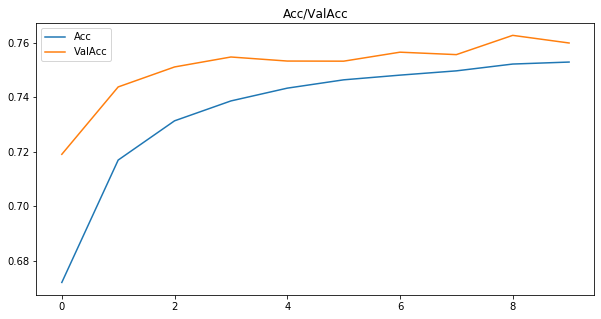

In [13]:
## Plot simples
fig = plt.figure(figsize=(10, 5))
plt.plot(hist.history["accuracy"], label='Acc')
plt.plot(hist.history["val_accuracy"], label='ValAcc')
plt.legend()
plt.title('Acc/ValAcc')
plt.show()
## Plot simples

In [14]:
# RMS
y_predict = modelLSTM.predict(X_test)
rms = sqrt(mean_squared_error(y_test, y_predict))
print(rms)

0.4014212427439192
